<a href="https://colab.research.google.com/github/mridulbiswas402/Bankloan/blob/master/personalloanpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following cell contains some useful functions which are used in this project
so that our project looks cleaner and can reuse the code again.

In [ ]:
# this function take dataframe as input it is to print description shape info of dataframe and returns list of contineous and discrete attribute name
def brief_info(df):
    discols=[]
    conticols=[]
    print(df.info())
    print(df.shape)
    print('Discrete columns are:')
    for cols in df.columns:
        if (df[cols].dtypes)=='int64':
            discols=discols+[cols]
    print(discols)       
    print('\n__________________________')
    print('Continous Columns are:')
    for cols in df.columns:
        if (df[cols].dtypes)!='int64':
            conticols=conticols+[cols]
    print(conticols)       
    return df.describe()

# this is to value_counts() of all the discrete columns
def valuecount(df,columnlist):
  for i in columnlist:
    print("----------",i,"-----------")
    print(df[i].value_counts())

# this to count plot of all discrete column in the dataframe
def showcount(df,dislist,target):
    l1=dislist
    print("------ Bivariate ------")
    for i in l1:
        sns.countplot(x=i,hue=target,data=df)
        plt.show()
    print("------ Univariate -----")  
    for i in l1:
        sns.countplot(data[i])
        plt.show()

# it shows the distribution of contineous columns
def showdist(dislist,df,target):
    l1=dislist
    print("---------- Bivariate ----------")
    for i in l1:
        fig=sns.FacetGrid(data=df,hue=target)
        fig.map(sns.kdeplot,i)
        fig.add_legend()
        plt.show()
    print("---------- Univariate ----------") 
    for i in l1:
        sns.distplot(df[i])
        plt.show()

# the function is to plot boxplot of all numerical attribute wrt categorical attribute
def showboxplot(conti,disc,data,target):
  for i in conti:
    print("------------ wrt ",i,"-------------")
    for j in disc: 
      sns.boxplot(x=j,y=i,hue=target,data=data)
      plt.show()

# this is to plot scatterplot all attribute wrt target attri      
def showscatterplot(dcol,ccol,data,target):
  print("---------- wrt ",target,"-----------")
  for i in ccol+dcol:  
    fig,ax = plt.subplots(figsize=(7,5))
    sns.scatterplot(x=i, y=target,hue=target, data=data)
    plt.show()
  print("------ among contineous columns ------")  
  for i in ccol:
    for j in ccol:
      fig,ax = plt.subplots(figsize=(7,5))
      sns.scatterplot(x=i, y=j,hue=target, data=data)
      plt.show()

# this function is transform the skewed attribute to non skewed normalized attribute      
def normalize(col,data):
  trnsdata = power_transform(data[col], method='yeo-johnson',standardize=True)
  trnsdata = pd.DataFrame(data=trnsdata,columns=col)
  data = data.drop(col,axis=1)
  data = pd.concat([data,trnsdata],axis=1)
  return data

# this function is to plot the roc_auc curve 
def Auc_curve(model,Xtest,ytest,ypredicted):
    #import sklearn.metrics as metrics
    probs = model.predict_proba(Xtest)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ytest, ypredicted)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# this function is to test different model on the given data and view different scores for classification problem
def modeltest(Xtrain,Xtest,ytrain,ytest,model):
        model.fit(Xtrain, ytrain)
        ypred = model.predict(Xtest)
        print("recall :",metrics.recall_score(ytest,ypred))
        print("acc :",metrics.accuracy_score(ytest,ypred))
        print("roc :",metrics.roc_auc_score(ytest,ypred))
        print("f1 :",metrics.f1_score(ytest,ypred))
        print("precision:",metrics.precision_score(ytest,ypred))
        Auc_curve(model,Xtest,ytest,ypred)
        matrix=confusion_matrix(ytest, ypred)
        print(matrix)

# the function Most_imp_feature() is for feature selection it implements 1) mutual_info_classif() 2) Randomforestclassifier() 3) REF()
# and output a list of names of column which are important common columns in all  
def Intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))
def Most_imp_feature(Xtrain,ytrain):
    mi=feature_selection.mutual_info_classif(Xtrain,ytrain)
    miser=pd.Series(mi)
    miser.index=Xtrain.columns.values
    m=miser.sort_values(ascending=False)
    robj=ensemble.RandomForestClassifier(n_estimators=200)
    robj.fit(Xtrain,ytrain)
    ser1=pd.Series(robj.feature_importances_)
    ser1.index=Xtrain.columns.values
    r=ser1.sort_values(ascending=False)
    rfeobj=feature_selection.RFE(estimator=linear_model.LogisticRegression(C=100,penalty="l2"),n_features_to_select=10)
    a=rfeobj.fit_transform(Xtrain,ytrain)
    f=list(Xtrain.columns[rfeobj.get_support()])
    lst1=[]
    for i in range(0,10):
        lst1=lst1+[m.index[i]]
    lst2=[]
    for i in range(0,10):
        lst2=lst2+[r.index[i]]
    
    intsec=Intersection(lst1, lst2)
    
    impfeature=Intersection(intsec, f)
    
    return impfeature

# this function is also for feature selection which implements chi2 test and outputs a list of features
def Chi2(Xtraindis,ytrain,dis):
    chiarr,parr=feature_selection.chi2(Xtraindis,ytrain)      # chi2 test for discrete values
    cols=dis
    ser=pd.Series(chiarr)
    ser.index=cols
    ch=ser.sort_values(ascending=False)
    lst1=[]
    for i in range(int(len(cols)/2)):
            lst1=lst1+[ch.index[i]]
    return lst1

# this function tests the given data on 4 different model 1) logistic regression 2)Randomforest 3)KNN 4) Naive bayes and outputs the performance score  of the
# models so that we can compare the results across the models.
def modelstats(Xtrain,Xtest,ytrain,ytest):
    stats=[]
    modelnames=["LR","Randomforest","KNN","NB"]
    models=list()
    models.append(linear_model.LogisticRegression())
    models.append(ensemble.RandomForestClassifier())
    models.append(neighbors.KNeighborsClassifier())
    models.append(naive_bayes.GaussianNB())
    for name,model in zip(modelnames,models):
        if name=="KNN":
            k=[l for l in range(5,17,2)]
            grid={"n_neighbors":k}
            grid_obj = GridSearchCV(estimator=model,param_grid=grid,scoring="f1")
            grid_fit =grid_obj.fit(Xtrain,ytrain)
            model = grid_fit.best_estimator_
            model.fit(Xtrain,ytrain)
            name=name+"("+str(grid_fit.best_params_["n_neighbors"])+")"
            print(grid_fit.best_params_)
        else:
            model.fit(Xtrain,ytrain)
        trainprediction=model.predict(Xtrain)
        testprediction=model.predict(Xtest)
        scores=list()
        scores.append(name+"-train")
        scores.append(metrics.accuracy_score(ytrain,trainprediction))
        scores.append(metrics.f1_score(ytrain,trainprediction))
        scores.append(metrics.precision_score(ytrain,trainprediction))
        scores.append(metrics.recall_score(ytrain,trainprediction))
        scores.append(metrics.roc_auc_score(ytrain,trainprediction))
        stats.append(scores)
        scores=list()
        scores.append(name+"-test")
        scores.append(metrics.accuracy_score(ytest,testprediction))
        scores.append(metrics.f1_score(ytest,testprediction))
        scores.append(metrics.precision_score(ytest,testprediction))
        scores.append(metrics.recall_score(ytest,testprediction))
        scores.append(metrics.roc_auc_score(ytest,testprediction))
        stats.append(scores)
    
    colnames=["MODELNAME","ACCURACY","f1","PRECISION","RECALL","AUC"]
    return pd.DataFrame(stats,columns=colnames),pd.crosstab(ytest,testprediction)

# this function does the stratified splitting of the data 
def splitdata(df,target,ts):
  split = StratifiedShuffleSplit(n_splits=1, test_size=ts, random_state=42)
  for train_index, valid_index in split.split(df, df[target]):
          train = df.loc[train_index]
          valid = df.loc[valid_index]
  train=train.reset_index(drop=True) 
  valid=valid.reset_index(drop=True)       
  return train,valid

Importing required library

In [ ]:
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import power_transform
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Loading Dataset into a Dataframe

In [ ]:
df=pd.read_csv("/content/sample_data/bankloan.csv")

The " brief_info(DataFrame) " prints information about datatype of attribute,null value,shape and gives a statistical summary of input dataframe

In [ ]:
brief_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB
None
(5000, 14)
Discrete columns are:
['ID', 'Age', 'Exp

ID          Age  ...       Online   CreditCard
count  5000.000000  5000.000000  ...  5000.000000  5000.000000
mean   2500.500000    45.338400  ...     0.596800     0.294000
std    1443.520003    11.463166  ...     0.490589     0.455637
min       1.000000    23.000000  ...     0.000000     0.000000
25%    1250.750000    35.000000  ...     0.000000     0.000000
50%    2500.500000    45.000000  ...     1.000000     0.000000
75%    3750.250000    55.000000  ...     1.000000     1.000000
max    5000.000000    67.000000  ...     1.000000     1.000000

[8 rows x 14 columns]

From the above description it is clear that the data doesnot have any NULL value or missing value.
but the experience column contains some negative value which is unexpected
I consider those -ve value as data entry error .
Thus taking absolute value of the experience column 

In [ ]:
df.Experience=df.Experience.abs()

0    90.4
1     9.6
Name: Personal Loan, dtype: float64


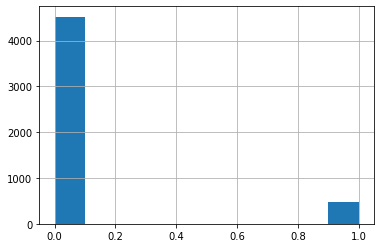

In [ ]:
df["Personal Loan"].hist()
print((df["Personal Loan"].value_counts()/df["Personal Loan"].count())*100)

The above code prints the distribution of the target column "Personal Loan".
It is clear that the data is very imbalanced and thus there is huge sampling bias.
i.e if we only predict every one will not take loan in that case we will be 90.4% accurate

The function " splitdata(dataframe,"target",size) " does stratified splitting of data and returns two dataframe train and valid

In [ ]:
data,valid = splitdata(df,"Personal Loan",0.25)

We divide the data in to 2 part one for training as "data" and other for testing as "valid"
from now we will keep the validation data aside an perform all analysis needed
on the training data only at last while evaluating we will use validation data.
This is very necessary step to reduce human bias from the model

In [ ]:
data

ID  Age  Experience  ...  CD Account  Online  CreditCard
0     1790   44          20  ...           1       1           1
1     1964   62          38  ...           0       0           1
2      386   35           9  ...           0       1           0
3     1418   42          18  ...           0       0           0
4      942   38          13  ...           0       0           0
...    ...  ...         ...  ...         ...     ...         ...
3745  4588   37          11  ...           0       0           0
3746  2342   36          10  ...           0       1           0
3747  1586   57          31  ...           0       0           0
3748  3153   40          15  ...           0       0           0
3749  4786   30           5  ...           0       1           0

[3750 rows x 14 columns]

In [ ]:
valid

ID  Age  Experience  ...  CD Account  Online  CreditCard
0     4973   58          32  ...           0       1           1
1     3350   55          25  ...           0       0           0
2     3549   40          16  ...           0       0           1
3      406   36          11  ...           1       1           1
4     4831   37          12  ...           0       1           0
...    ...  ...         ...  ...         ...     ...         ...
1245   260   56          30  ...           0       1           0
1246  3647   34           9  ...           0       1           0
1247  4058   57          32  ...           0       0           0
1248  2122   41          17  ...           0       0           1
1249  3877   35          11  ...           0       1           0

[1250 rows x 14 columns]

According to data description "Income" is income of customer per year and "CCAvg" is the Credit Card spending of the customer 
if do (income-ccavg*12) we will get customers rough yearly average savings 
let make a new column called "Avgsaving" which is rough yearly avg saving of customer and analize if it comes out to be helpfull or not  

In [ ]:
data["Avgsavings"]=(data["Income"]-(data["CCAvg"]*12))

In [ ]:
brief_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 1789 to 4785
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3750 non-null   int64  
 1   Age                 3750 non-null   int64  
 2   Experience          3750 non-null   int64  
 3   Income              3750 non-null   int64  
 4   ZIP Code            3750 non-null   int64  
 5   Family              3750 non-null   int64  
 6   CCAvg               3750 non-null   float64
 7   Education           3750 non-null   int64  
 8   Mortgage            3750 non-null   int64  
 9   Personal Loan       3750 non-null   int64  
 10  Securities Account  3750 non-null   int64  
 11  CD Account          3750 non-null   int64  
 12  Online              3750 non-null   int64  
 13  CreditCard          3750 non-null   int64  
 14  Avgsavings          3750 non-null   float64
dtypes: float64(2), int64(13)
memory usage: 468.8 KB
None

ID          Age  ...   CreditCard   Avgsavings
count  3750.000000  3750.000000  ...  3750.000000  3750.000000
mean   2495.327467    45.375467  ...     0.287733     4.216664
std    1451.063617    11.488909  ...     0.452767     3.052538
min       1.000000    23.000000  ...     0.000000    -0.333333
25%    1238.250000    35.000000  ...     0.000000     1.883333
50%    2491.000000    45.000000  ...     0.000000     3.383333
75%    3761.750000    55.000000  ...     1.000000     5.912500
max    5000.000000    67.000000  ...     1.000000    16.166667

[8 rows x 15 columns]

The following code prints the no of unique values in each column

In [ ]:
# no of unique in each row
data.nunique()

ID                    3750
Age                     45
Experience              44
Income                 162
ZIP Code               465
Family                   4
CCAvg                  107
Education                3
Mortgage               315
Personal Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
Avgsavings            1107
dtype: int64

From the above analysis we consider ['Income','Mortgage','CCAvg','Age', 'Experience','Avgsavings'] as our numerical or continous attribute
and rest of all as categorical or discrete attribute.
although the ZIP code is categorical due to many unique value it seems it is not going to be usefull

In [ ]:
conattri=['Income','Mortgage','CCAvg','Age', 'Experience','Avgsavings']        # list of numerical attribute 
disattri=['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']    # list of categorical attribute 

the function "valuecount(data,list of discrete attribute)" prints the value_counts() of each categorical attribute

In [ ]:
valuecount(data,disattri)

---------- Family -----------
1    1139
2     958
4     896
3     757
Name: Family, dtype: int64
---------- Education -----------
1    1579
3    1140
2    1031
Name: Education, dtype: int64
---------- Securities Account -----------
0    3356
1     394
Name: Securities Account, dtype: int64
---------- CD Account -----------
0    3518
1     232
Name: CD Account, dtype: int64
---------- Online -----------
1    2247
0    1503
Name: Online, dtype: int64
---------- CreditCard -----------
0    2671
1    1079
Name: CreditCard, dtype: int64


from the above it is clear that the "CD Account" and "Securities Account" are very imbalanced

In [ ]:
#no of people with 0 Mortgage and CCAvg
print((data.Mortgage==0).sum())
print((data.CCAvg==0).sum()) 
print((data.Income==0).sum()) 

2605
76
0


the function "showcount(data,list of categorical attri, 'target')" shows the hist plot of all categorical attribute

------ Bivariate ------


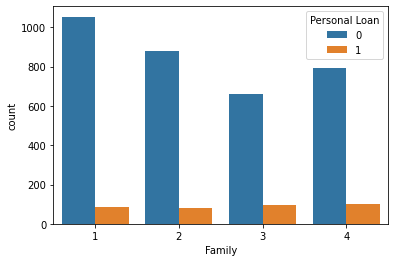

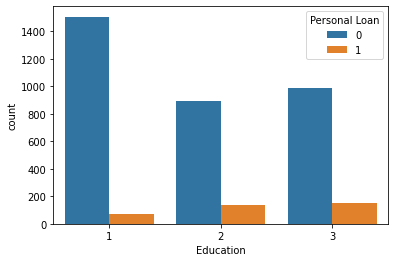

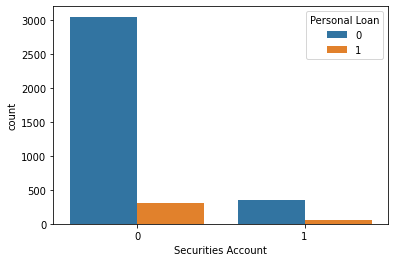

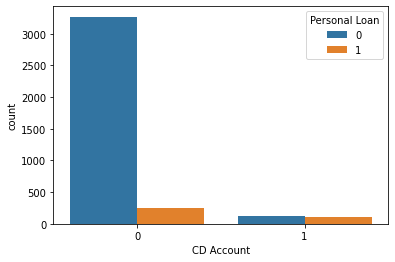

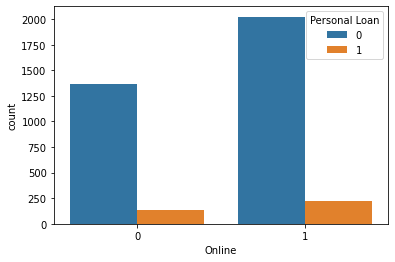

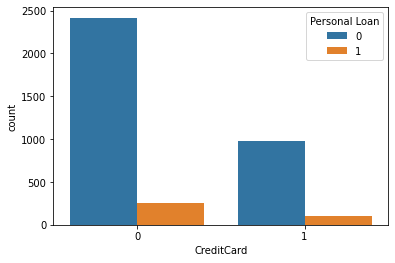

------ Univariate -----


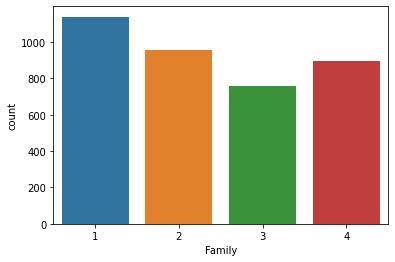

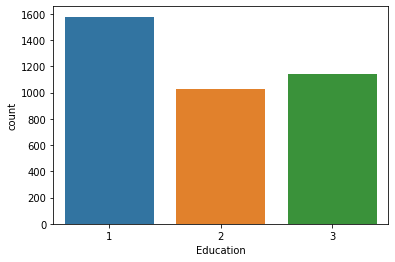

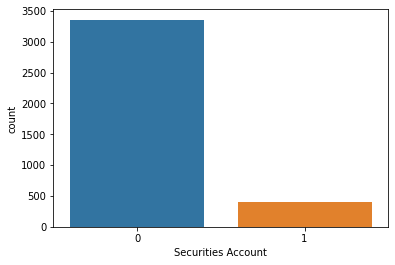

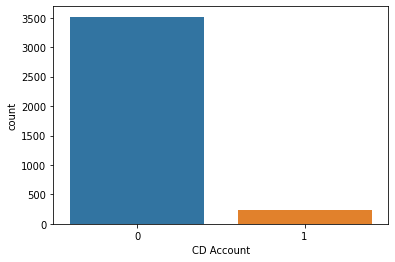

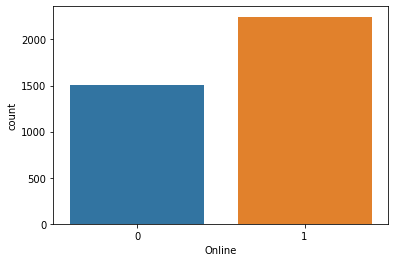

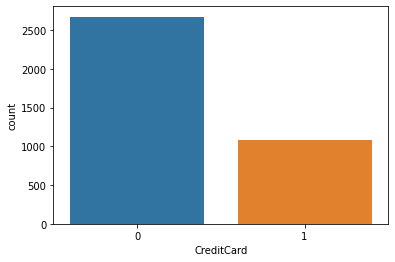

In [ ]:
showcount(data,disattri,"Personal Loan")

Conclusion of the above analysis are :
* less family member => less likely to take loan
* the people with level 3 education level has taken more loan compare to level 1
* most of the people doesnot haveing security account has not taken loan
* most of the people doesnot having CD account have not taken loan and who has cd account proportion of taking loan and not taking loan is equal



the function "showdist(list of numerical attri,data,"target")" shows the distribution of numerical attribute

---------- Bivariate ----------


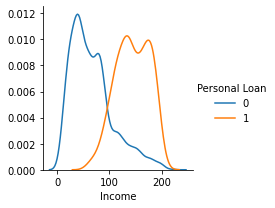

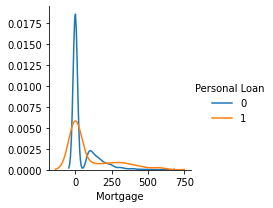

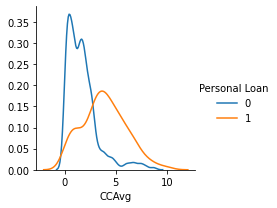

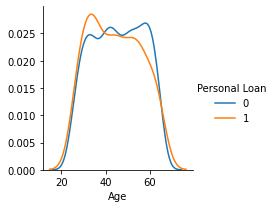

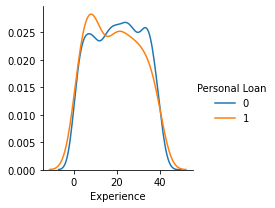

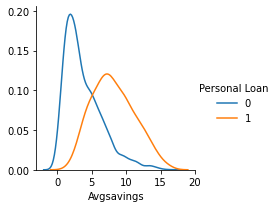

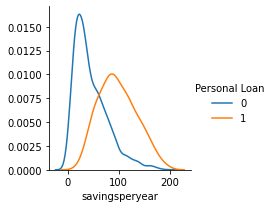

---------- Univariate ----------


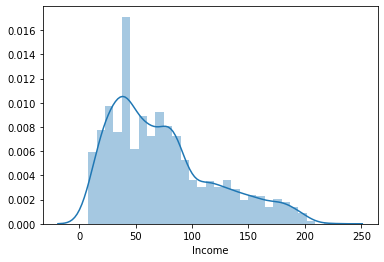

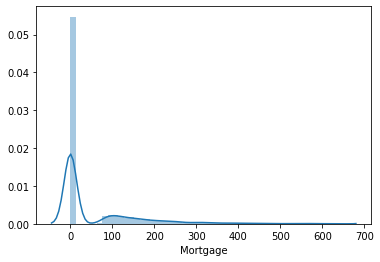

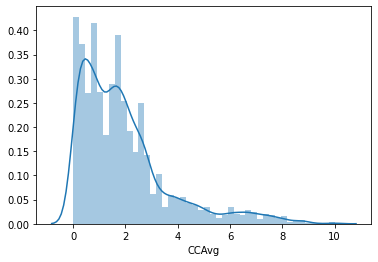

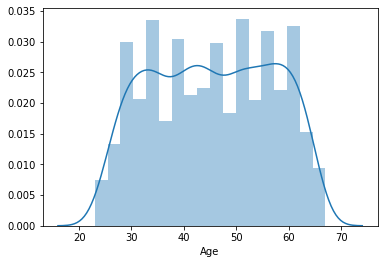

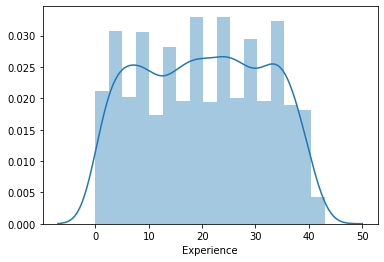

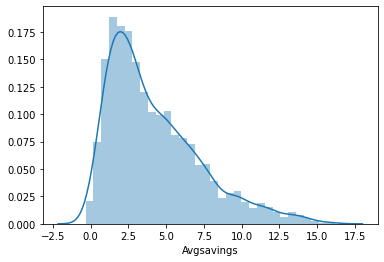

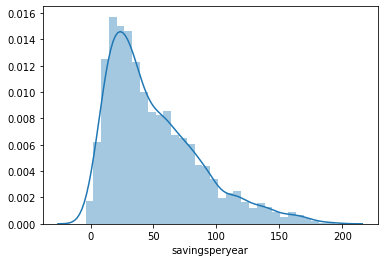

In [ ]:
showdist(conattri,data,"Personal Loan")

from the above diagram it is clear we have very skewed column like Mortgage,CCAvg, Avgsavings,Income we need to transform those column to reduce the skewness.
conclusion of the above analysis:
* people not taking loan have very left skewed income distribution same is with CCAvg
* Avgsavings have quit smoother left skewed distribution which means that if we reduce it skewness and normalize we will get an almost perfect normal distribution
* age and experience have same uniform kind of distribution just age is 20 unit right shifted so we can consider any one of them and left other 

the function "showboxplot(numattri,categoricalattri,data,"target")" plots the box plot of all numerical attribut wrt categorical attribute.

------------ wrt  Income -------------


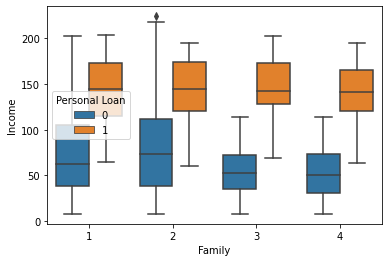

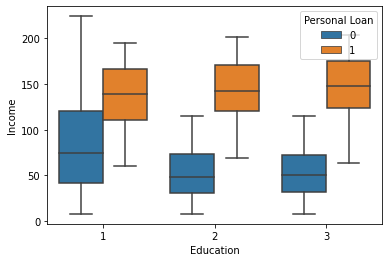

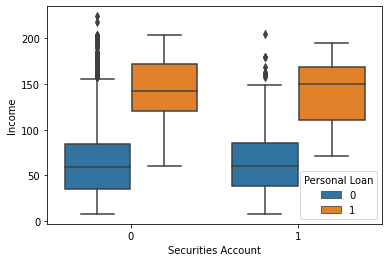

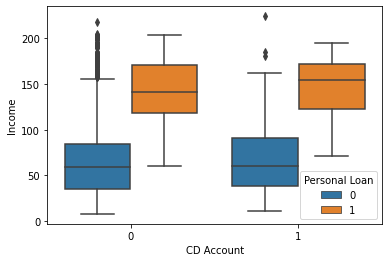

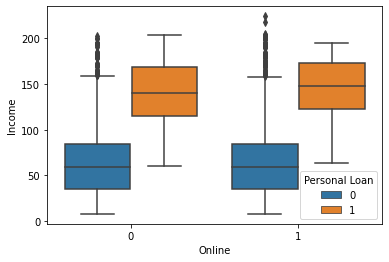

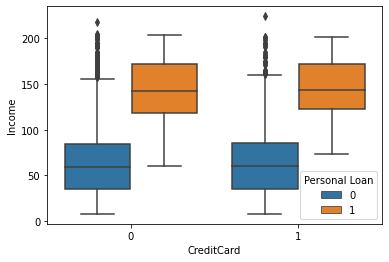

------------ wrt  Mortgage -------------


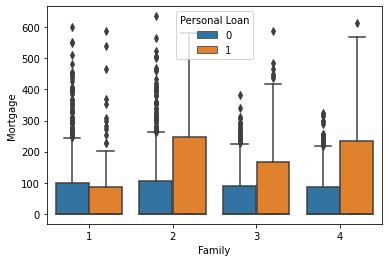

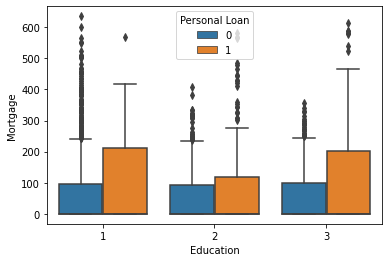

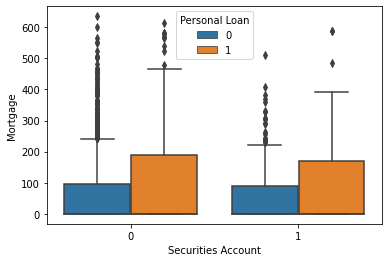

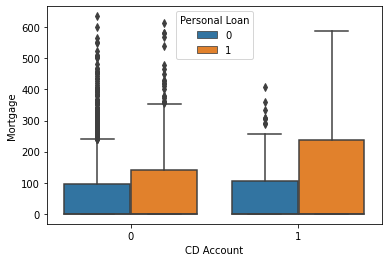

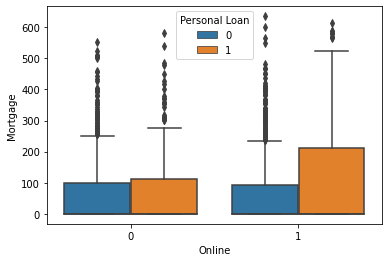

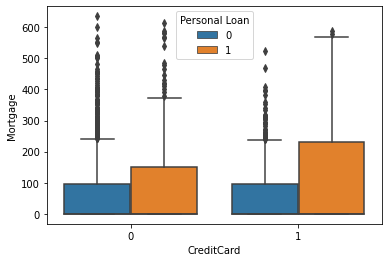

------------ wrt  CCAvg -------------


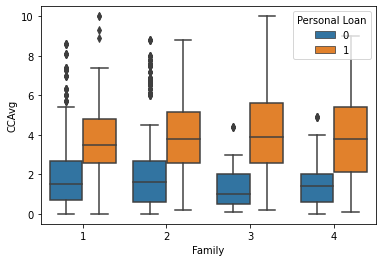

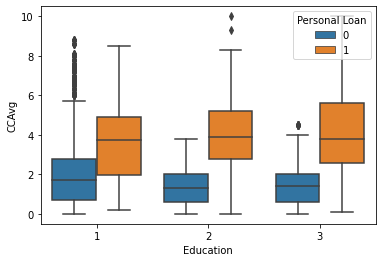

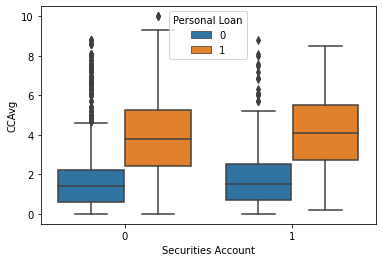

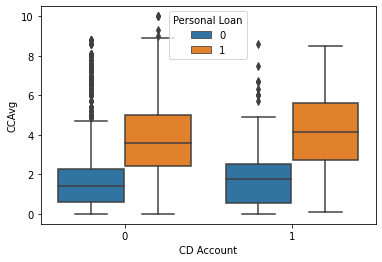

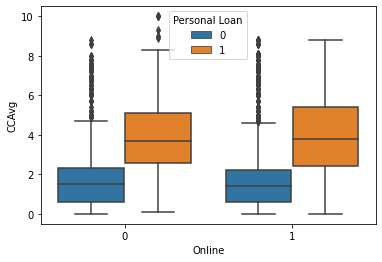

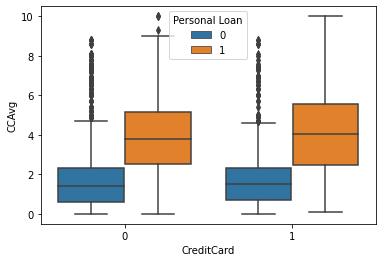

------------ wrt  Age -------------


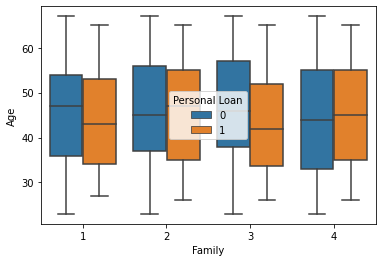

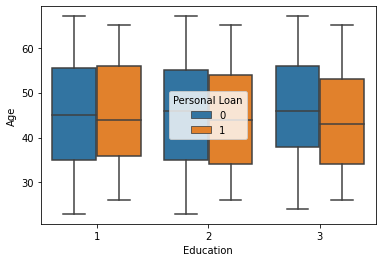

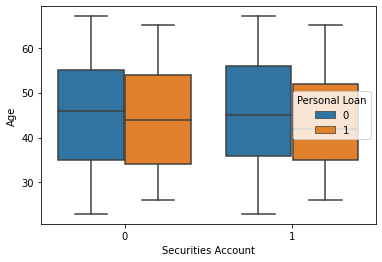

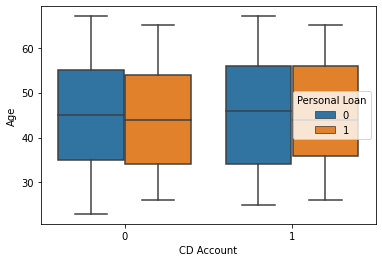

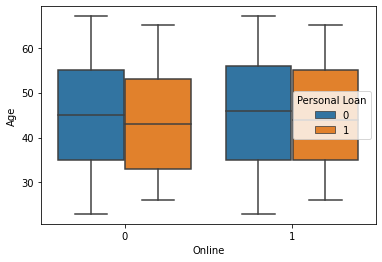

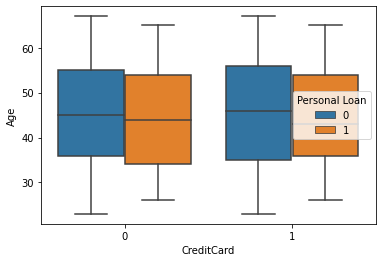

------------ wrt  Experience -------------


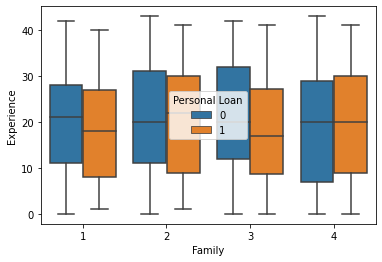

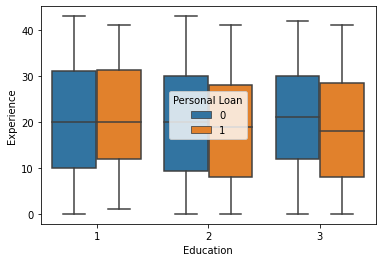

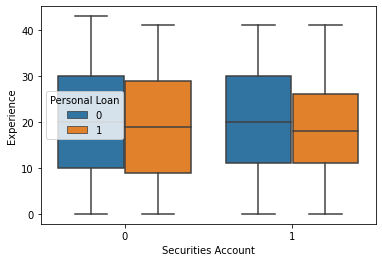

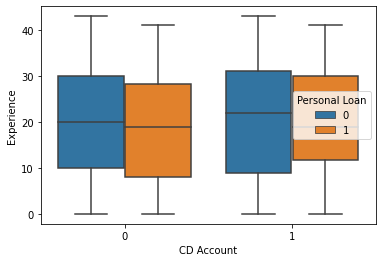

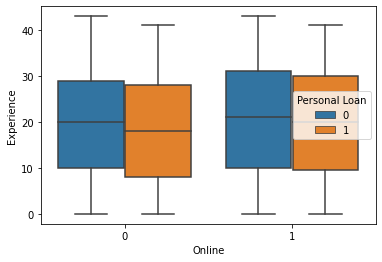

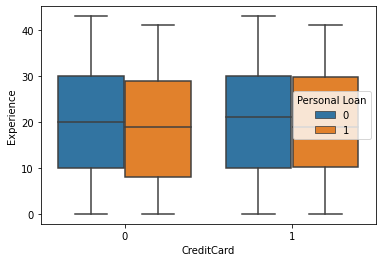

------------ wrt  Avgsavings -------------


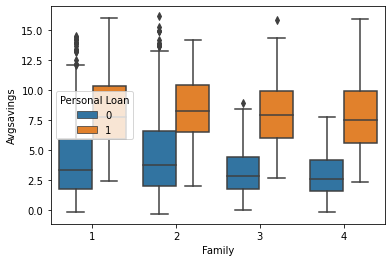

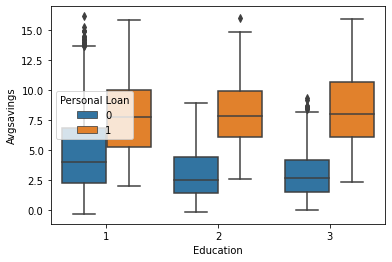

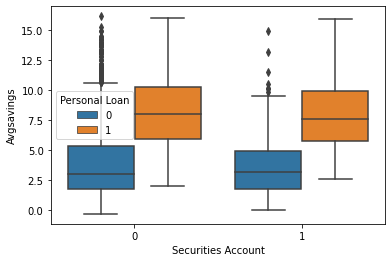

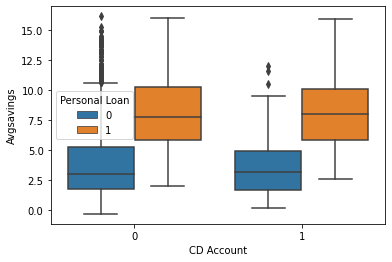

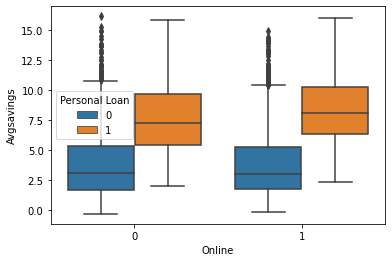

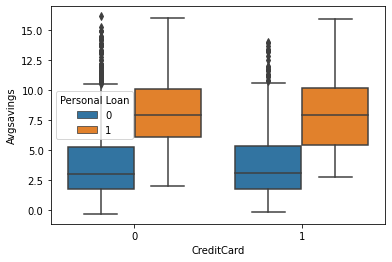

------------ wrt  savingsperyear -------------


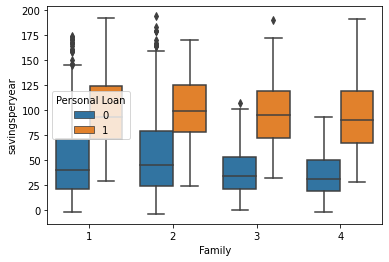

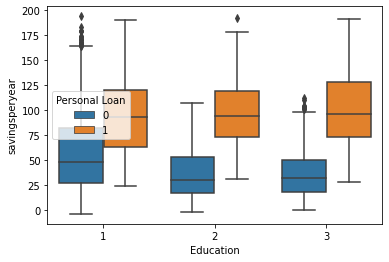

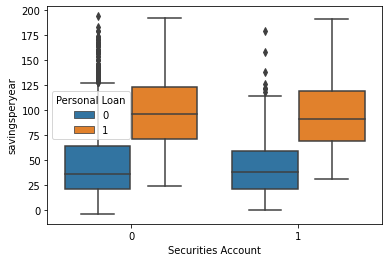

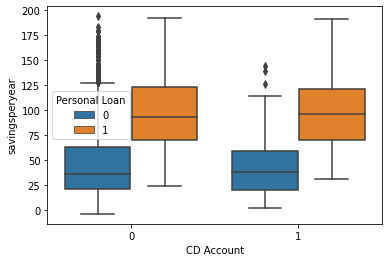

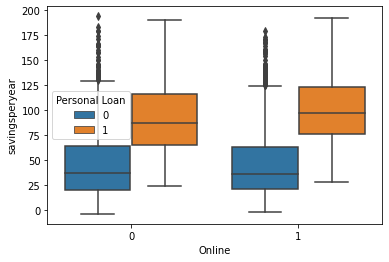

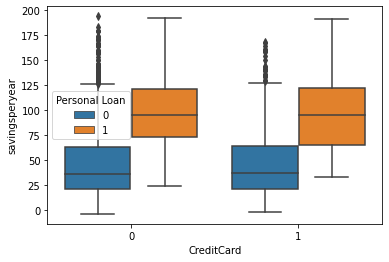

In [ ]:
showboxplot(conattri,disattri,data,"Personal Loan")

conclusion of the above analysis:
 * Mortgage seems to have a very high no of outliers it also does not seems to give any usefull information 

The following code prints the correlation of predictor column wrt target column 

In [ ]:
(data[data.columns[1:]].corr()['Personal Loan'][:]).sort_values()

Age                  -0.029091
Experience           -0.028898
ZIP Code             -0.011781
CreditCard            0.004831
Online                0.013462
Securities Account    0.032992
Family                0.061172
Education             0.130019
Mortgage              0.136306
CD Account            0.337145
CCAvg                 0.364848
savingsperyear        0.420470
Avgsavings            0.420470
Income                0.498000
Personal Loan         1.000000
Name: Personal Loan, dtype: float64

 * correlation of creditcard is negligible it seems we can discard it.
 * important features seems to be income,avgsavings,ccavg,cdaccount 

following code plots the corr among the predictor column

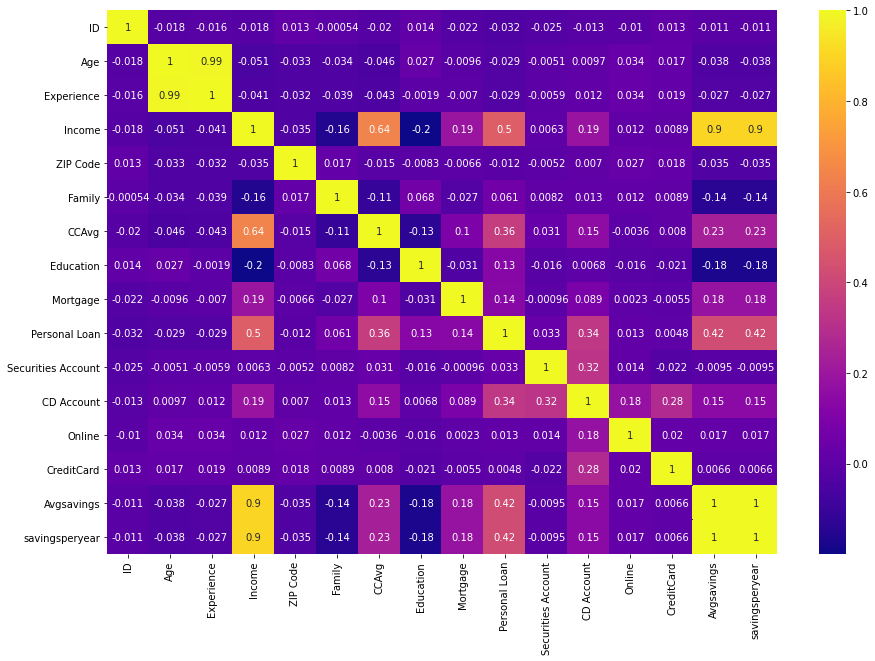

In [ ]:
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(),cmap='plasma',annot= True)

* correlation ammong predictor column should be as less as possible
* correlation among age and experience is very high so we have discard one of them
* corr among avgsaving and income is also high so we will keep avgsaving due to its smoother distribution. 

the function "showscatterplot(categorical attribute,numerical attribute,data,target)" shows scatterplot of all numerical attri wrt target and among numerical attri.

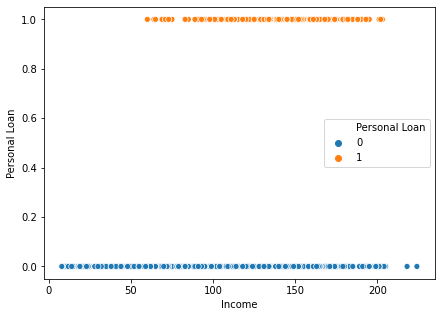

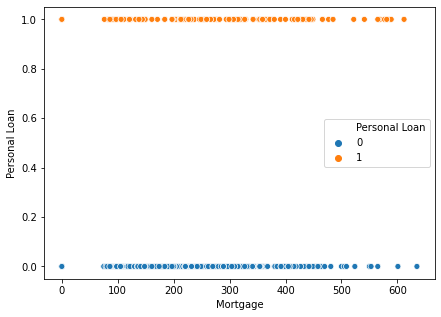

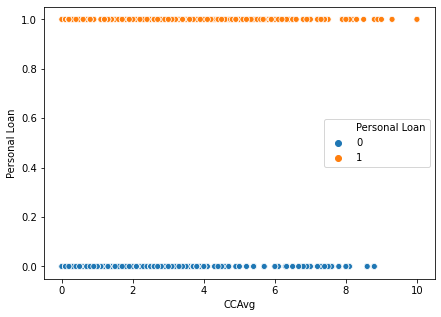

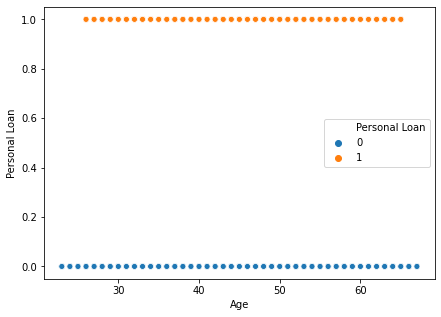

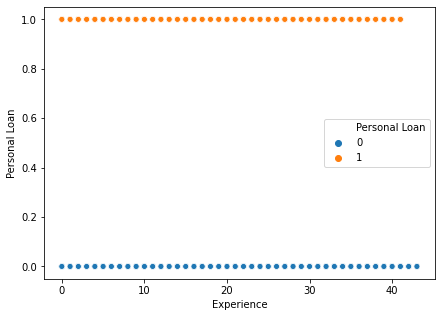

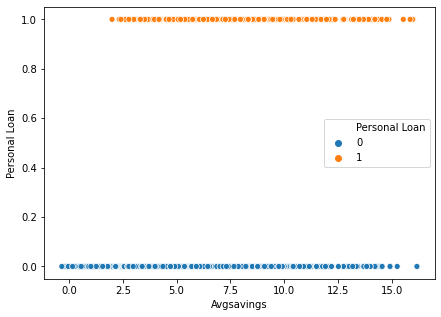

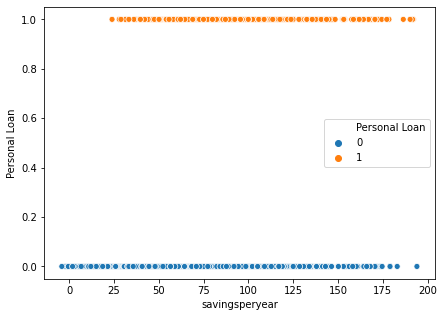

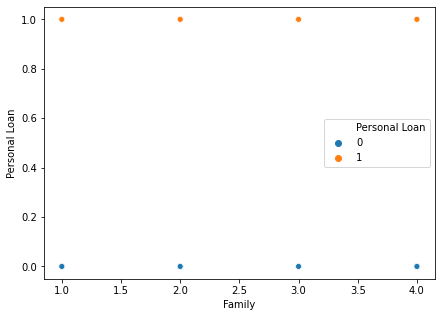

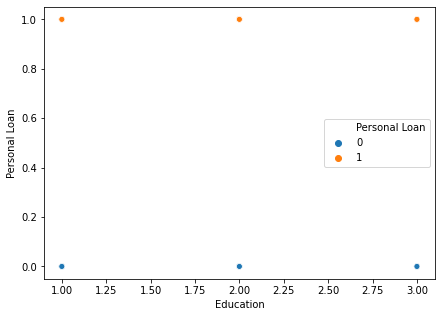

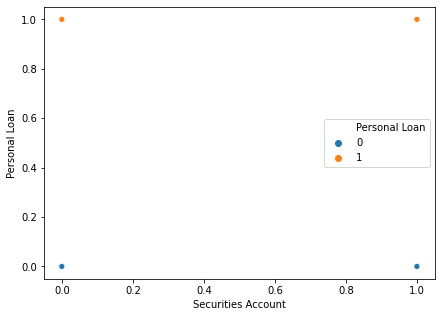

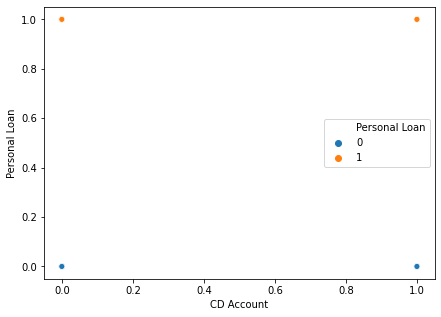

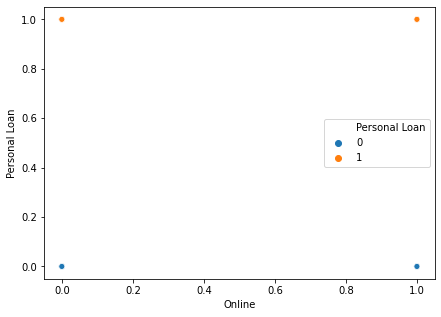

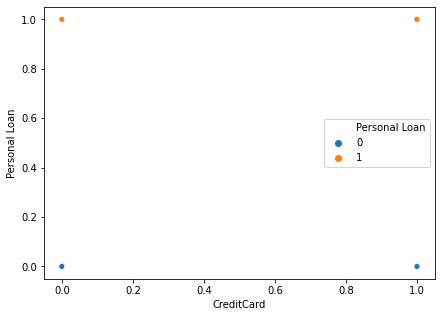

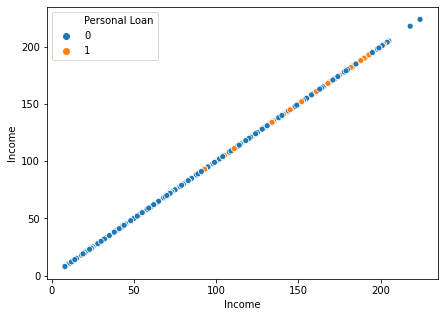

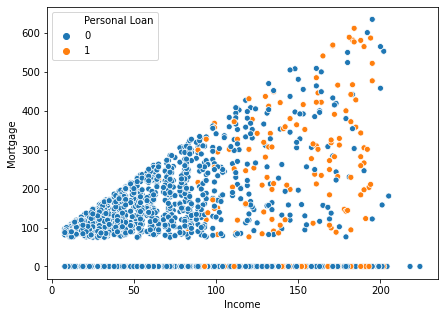

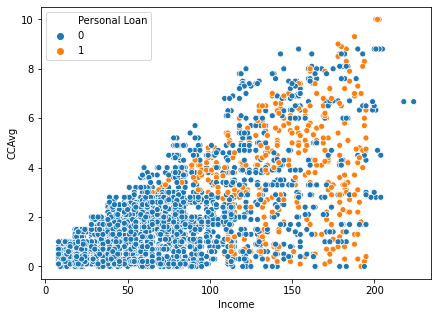

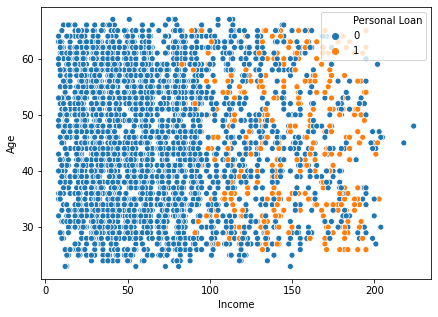

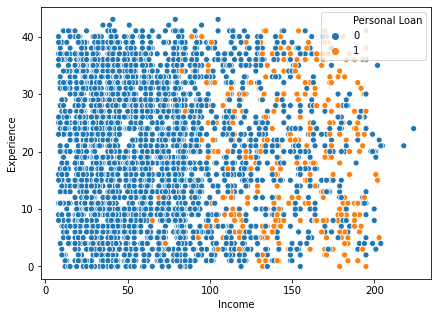

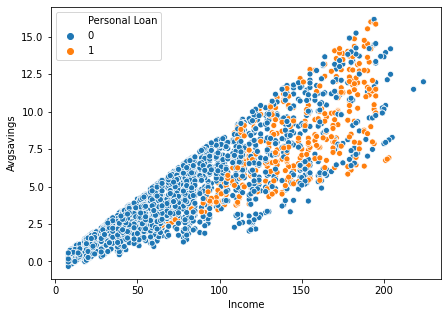

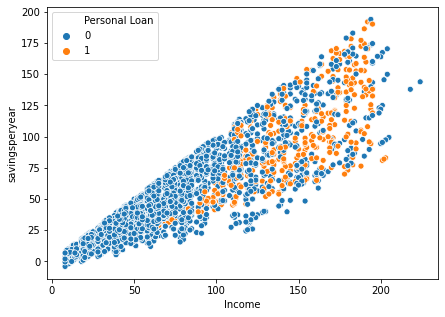

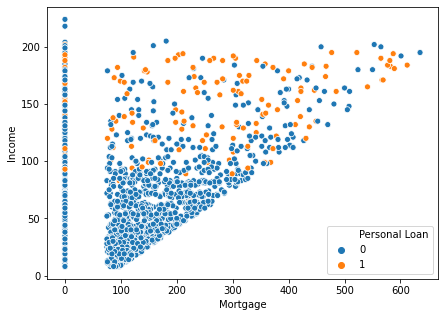

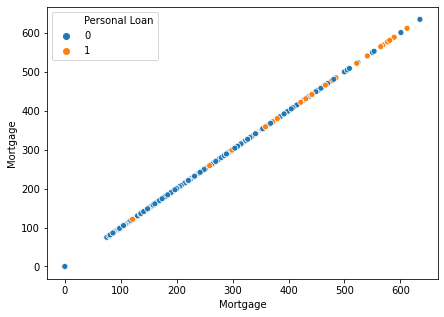

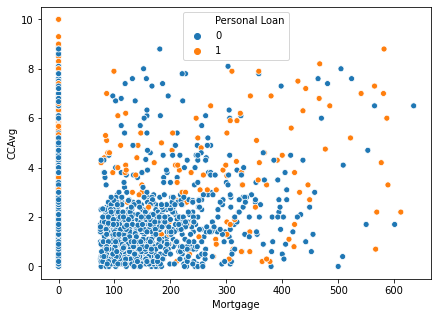

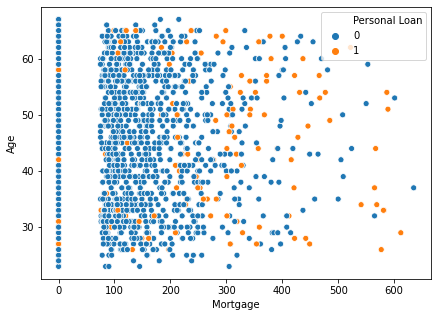

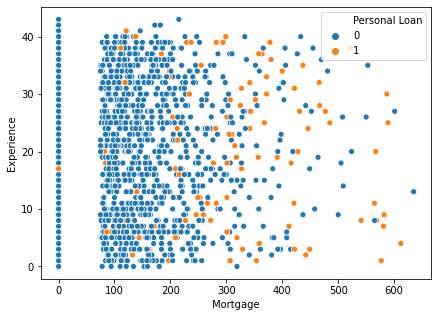

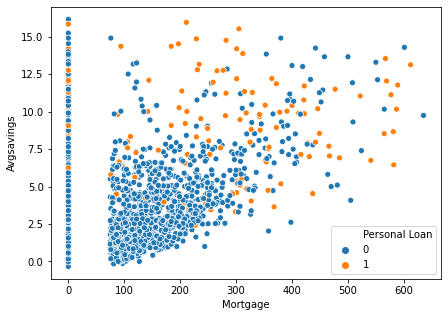

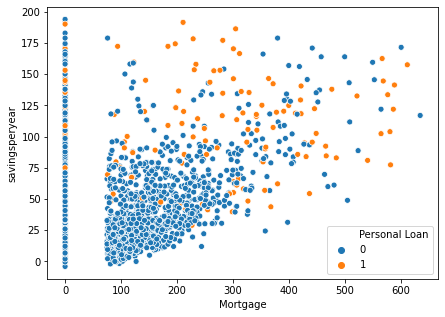

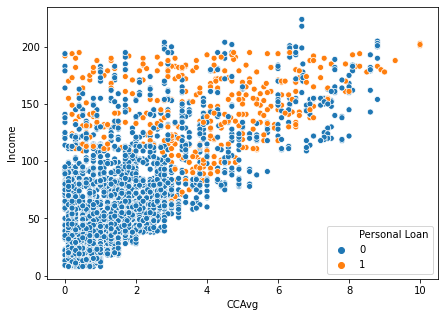

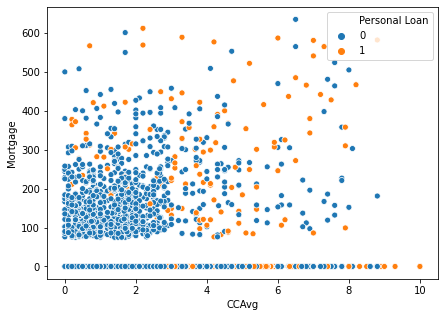

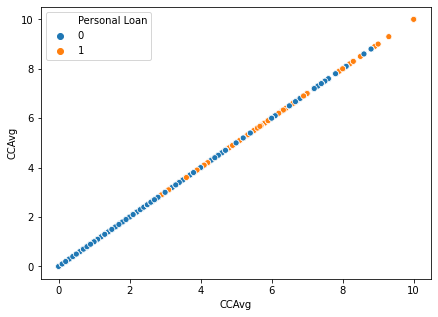

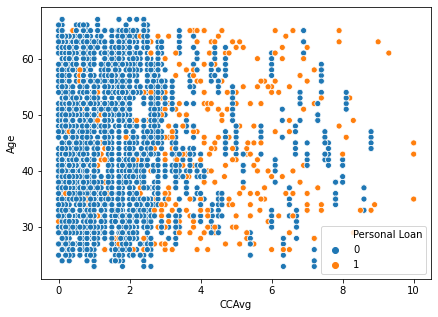

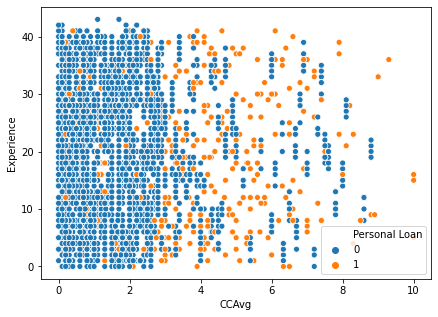

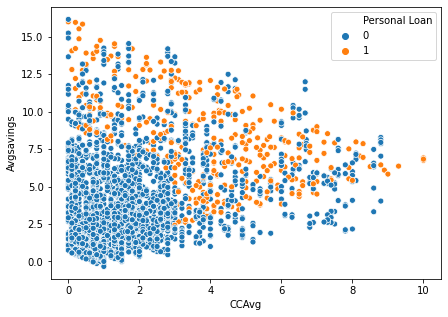

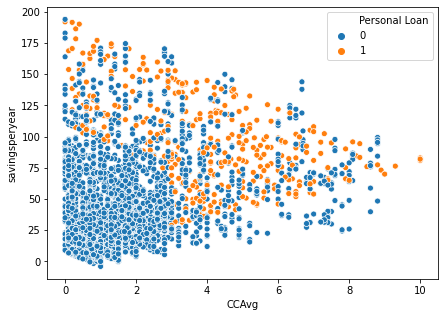

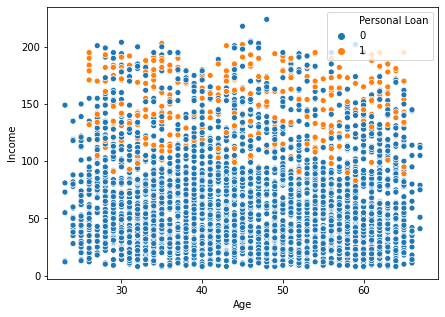

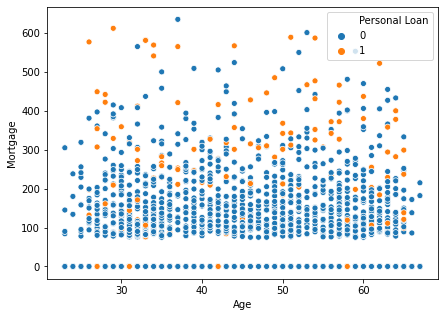

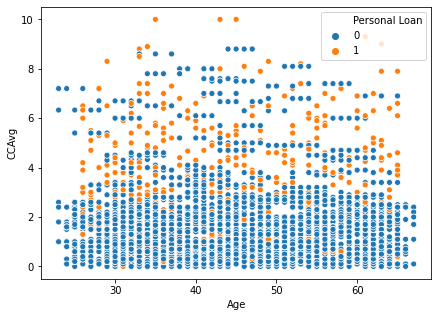

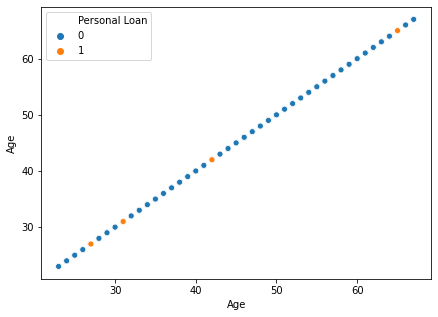

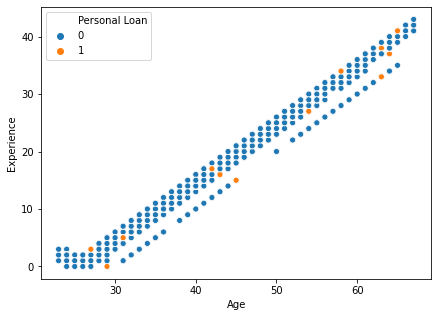

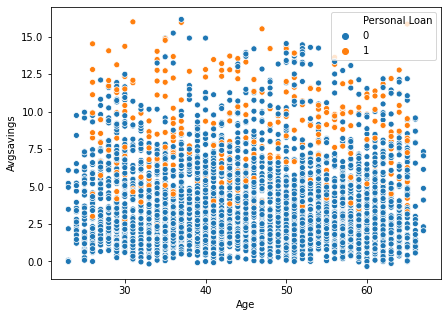

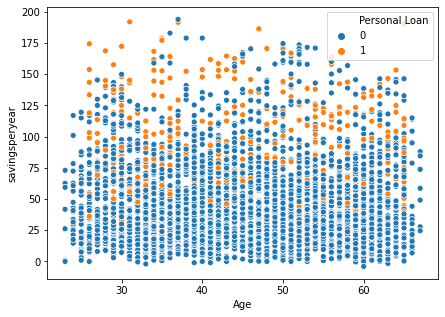

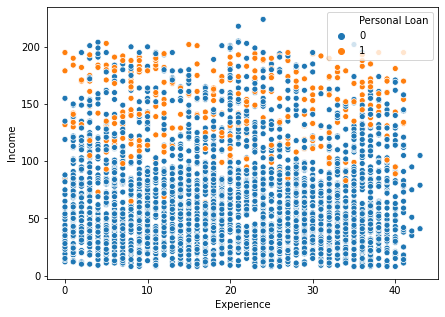

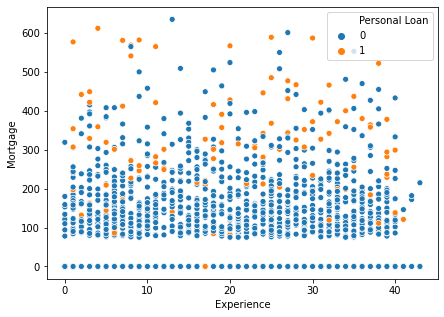

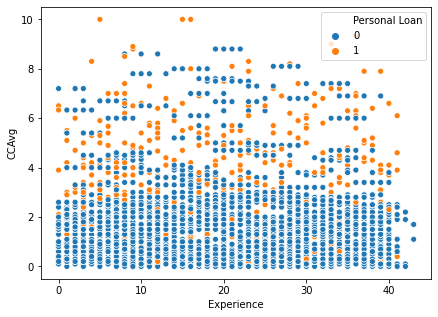

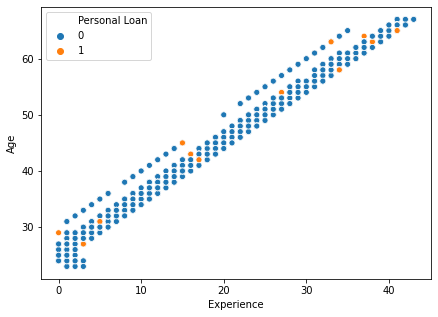

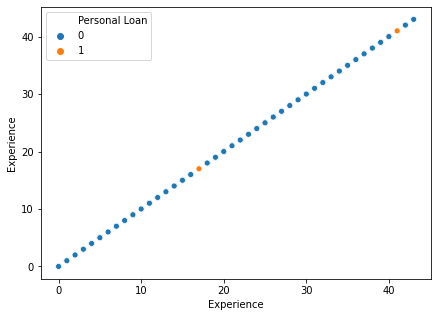

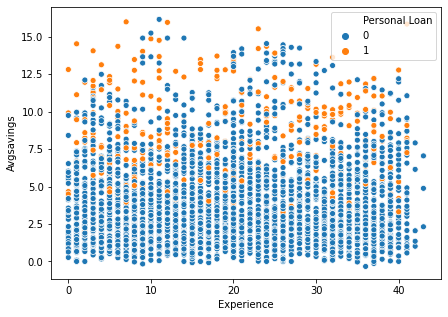

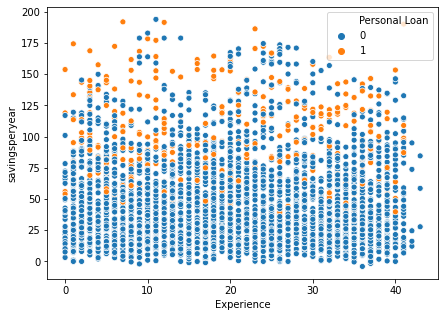

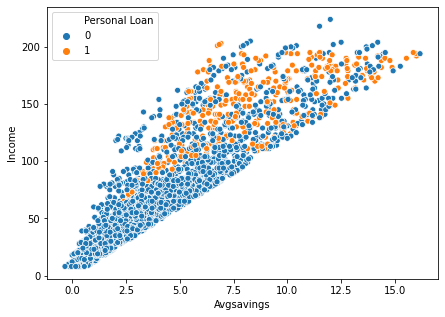

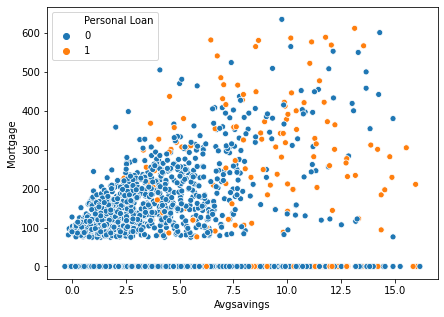

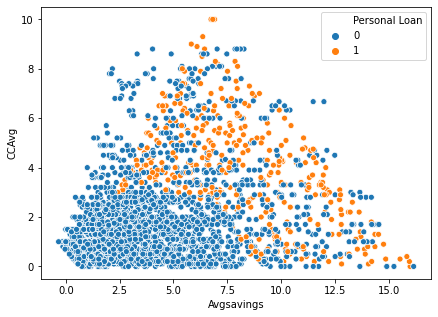

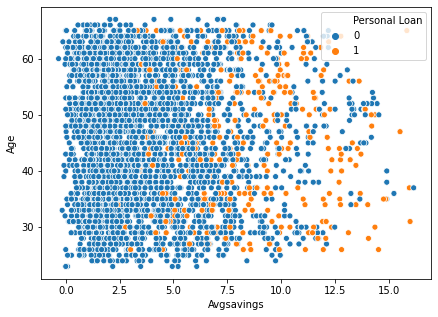

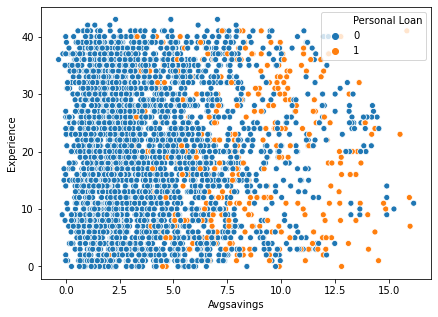

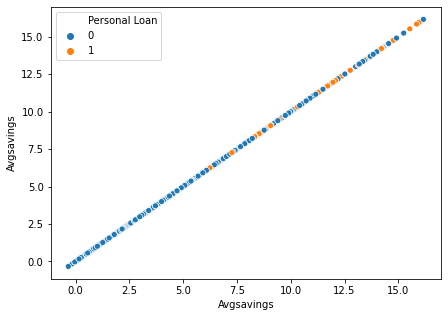

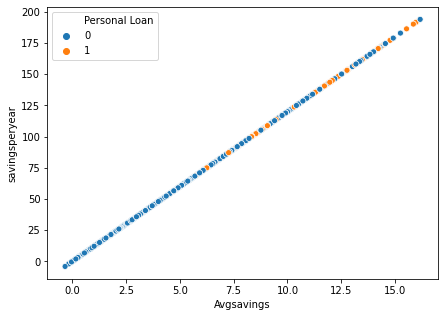

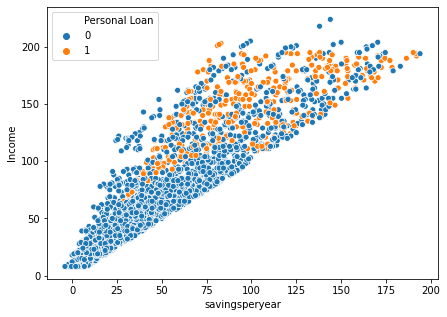

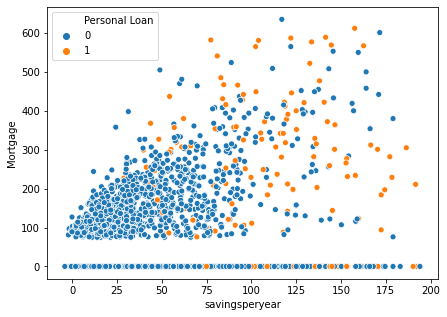

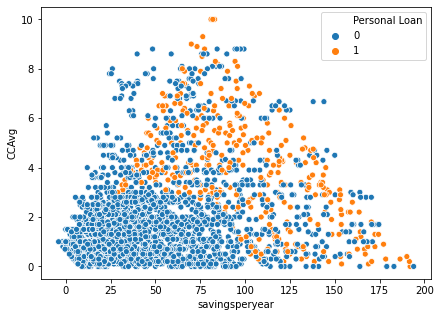

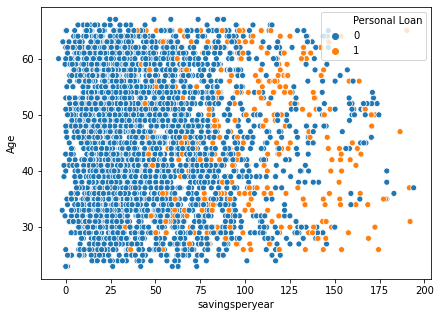

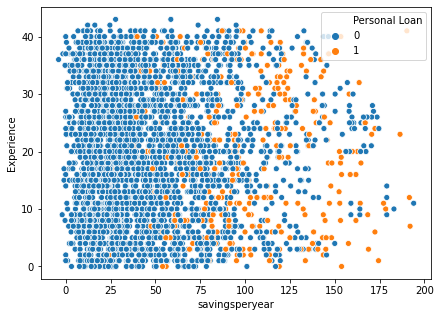

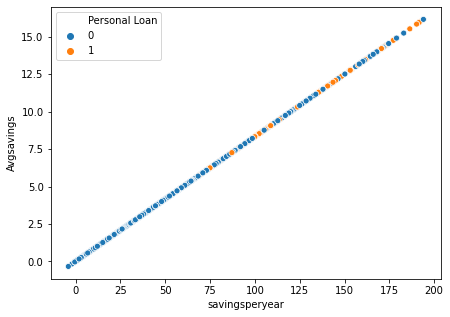

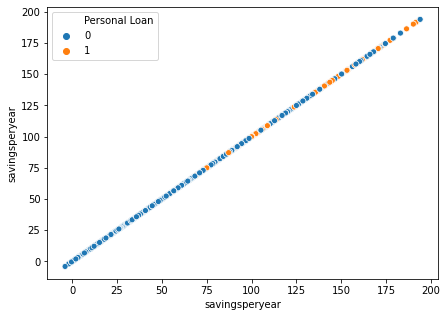

In [ ]:
showscatterplot(disattri,conattri,data,'Personal Loan')

* mortgage ,age , experience seems to be use less
and other information are same as before.

In [ ]:
data[:20]

ID  Age  Experience  Income  ...  CD Account  Online  CreditCard  Avgsavings
0   1790   44          20     171  ...           1       1           1       162.6
1   1964   62          38      50  ...           0       0           1        36.8
2    386   35           9      40  ...           0       1           0        29.2
3   1418   42          18      52  ...           0       0           0        22.0
4    942   38          13     129  ...           0       0           0        76.2
5   4749   43          18      38  ...           0       1           0        32.0
6   4799   44          20      62  ...           0       0           1        58.4
7   1026   62          37      50  ...           0       1           0        32.0
8   3272   52          27      93  ...           0       0           1        43.8
9   2933   41          16     154  ...           0       0           1        70.0
10  1390   45          15      20  ...           0       1           0        11.0
11  2406   57          32      13  ...           0       1           0         2.2
12  2000   48          22      80  ...           0       1           0        51.2
13   563   28           3      85  ...           0       1           1        75.4
14  2352   55          31      74  ...           0       1           1        35.6
15  2369   48          22      78  ...           0       1           1        52.8
16  4155   51          25     163  ...           0       1           0       147.4
17  2470   43          18      89  ...           0       0           1        87.8
18  2006   47          23     170  ...           1       1           1        92.0
19  4546   61          35      35  ...           0       1           0        32.6

[20 rows x 15 columns]

the following are the list of all skewed column

In [ ]:
skew=['Income','Mortgage','CCAvg','Avgsavings'] 

the function "normalize(list of skew column,data)" performs power_transformation on the skewed data and then normalize them and returns a dataframe with transformed column

In [ ]:
data=normalize(skew,data)

In [ ]:
data

ID  Age  Experience  ZIP Code  ...    Income  Mortgage     CCAvg  Avgsavings
0     1790   44          20     91330  ...  1.694401  1.597486 -0.724653    2.208465
1     1964   62          38     94539  ... -0.339489 -0.662796 -0.290000   -0.175035
2      386   35           9     93943  ... -0.643880 -0.662796 -0.492805   -0.442803
3     1418   42          18     94061  ... -0.284107 -0.662796  0.664594   -0.740354
4      942   38          13     92093  ...  1.170104  1.500533  1.378595    0.833311
...    ...  ...         ...       ...  ...       ...       ...       ...         ...
3745  4588   37          11     94720  ... -0.101851 -0.662796 -1.496982    0.388696
3746  2342   36          10     92028  ...  0.571014  1.559142  0.050587    0.766156
3747  1586   57          31     90502  ...  1.197765 -0.662796  0.760786    1.259419
3748  3153   40          15     90275  ...  0.421758 -0.662796 -0.388188    0.723227
3749  4786   30           5     94304  ... -1.324341 -0.662796 -0.492805   -1.264928

[3750 rows x 15 columns]

the following shows the distribution of the numerical column after transformation 

---------- Bivariate ----------


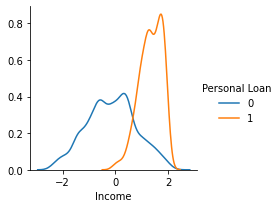

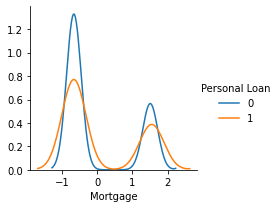

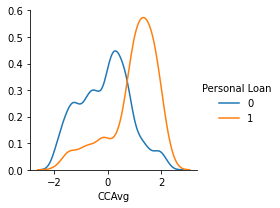

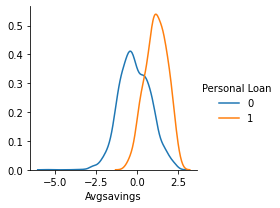

---------- Univariate ----------


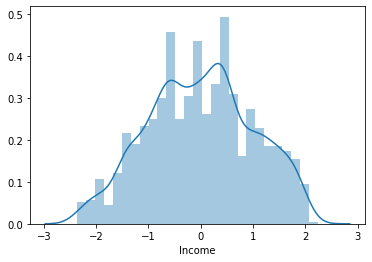

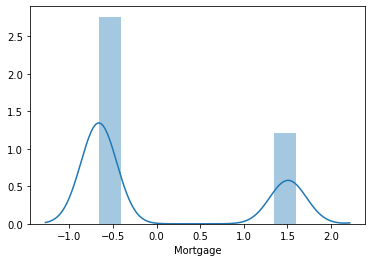

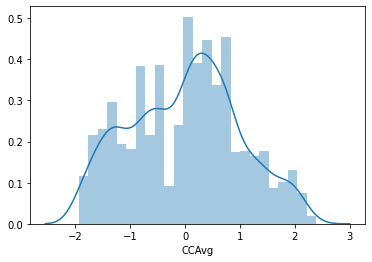

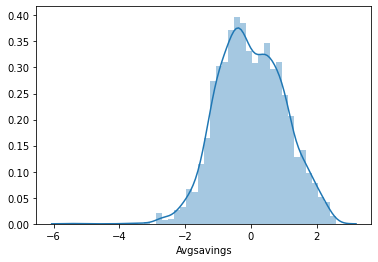

In [ ]:
showdist(skew,data,'Personal Loan')

as mentioned earlier the distribution of avgsavings seems to more approx to normal curve compare to income from which it was initially created

In [ ]:
Xtrain=data.drop(['Personal Loan'],axis=1)
ytrain=data["Personal Loan"]

In [ ]:
mi=feature_selection.mutual_info_classif(Xtrain,ytrain)
miser=pd.Series(mi)
miser.index=Xtrain.columns.values
m=miser.sort_values(ascending=False)
print(m)

Income                0.130209
CCAvg                 0.105824
Avgsavings            0.088225
CD Account            0.030227
Education             0.015784
Mortgage              0.012342
ID                    0.007017
Experience            0.006159
Online                0.005907
Family                0.004772
ZIP Code              0.004698
Securities Account    0.002273
Age                   0.001598
CreditCard            0.000000
dtype: float64


income, ccavg, avgsavings are important according to mutual_info_classif()

In [ ]:
robj=ensemble.RandomForestClassifier(n_estimators=200)
robj.fit(Xtrain,ytrain)
ser1=pd.Series(robj.feature_importances_)
ser1.index=Xtrain.columns.values
r=ser1.sort_values(ascending=False)
print(r)

Income                0.230681
Education             0.172329
CCAvg                 0.141286
Avgsavings            0.133812
Family                0.107187
CD Account            0.054321
ID                    0.029458
Age                   0.028896
ZIP Code              0.028619
Mortgage              0.028297
Experience            0.027624
CreditCard            0.007713
Online                0.005569
Securities Account    0.004210
dtype: float64


income,education,ccavg,avgsavings,family is important according to RFC

In [ ]:
model = ExtraTreesClassifier()
model.fit(Xtrain,ytrain)
ser1=pd.Series(model.feature_importances_)
ser1.index=Xtrain.columns.values
r=ser1.sort_values(ascending=False)
print(r)


Income                0.249954
Education             0.136311
Avgsavings            0.132631
CCAvg                 0.120186
CD Account            0.088427
Family                0.078966
Age                   0.034088
Experience            0.032520
ID                    0.031357
ZIP Code              0.030997
CreditCard            0.020762
Mortgage              0.020157
Online                0.014310
Securities Account    0.009334
dtype: float64


income,education,avgsaving,ccavg is more important according to ETC

the function "chi2(discrete column data,data,categorical attribute)" performs chi2 test and gives best attribute that are relevant for predicting the target 

In [ ]:
ch=Chi2(Xtrain[disattri],ytrain,disattri)

In [ ]:
ch

['CD Account', 'Education', 'Family']

above are the relevant attribute 

In [ ]:
dropfeatures=['ZIP Code', 'Securities Account', 'Online', 'CreditCard', 'Mortgage','Experience','ID','Age','Income']

from above all analysis I consider to drop those above columns and keep the rest

In [ ]:
Xtrain=Xtrain.drop(dropfeatures,axis=1)

the following is how our training data looks after transformation and feature selection we have keep only Family,CD account,Education,Avgsavings,ccvg

In [ ]:
Xtrain

Family  Education  CD Account     CCAvg  Avgsavings
0          4          1           1 -0.724653    2.208465
1          2          1           0 -0.290000   -0.175035
2          3          1           0 -0.492805   -0.442803
3          2          1           0  0.664594   -0.740354
4          4          1           0  1.378595    0.833311
...      ...        ...         ...       ...         ...
3745       4          3           0 -1.496982    0.388696
3746       1          3           0  0.050587    0.766156
3747       2          1           0  0.760786    1.259419
3748       1          3           0 -0.388188    0.723227
3749       2          3           0 -0.492805   -1.264928

[3750 rows x 5 columns]

In [ ]:
valid

ID  Age  Experience  ...  CD Account  Online  CreditCard
0     4973   58          32  ...           0       1           1
1     3350   55          25  ...           0       0           0
2     3549   40          16  ...           0       0           1
3      406   36          11  ...           1       1           1
4     4831   37          12  ...           0       1           0
...    ...  ...         ...  ...         ...     ...         ...
1245   260   56          30  ...           0       1           0
1246  3647   34           9  ...           0       1           0
1247  4058   57          32  ...           0       0           0
1248  2122   41          17  ...           0       0           1
1249  3877   35          11  ...           0       1           0

[1250 rows x 14 columns]

we perform all the transformation which we have performed on training data to our validation data

In [ ]:
valid["Avgsavings"]=(valid["Income"]-(valid["CCAvg"]*12))
valid=normalize(skew,valid)
Xtest=valid.drop(['Personal Loan'],axis=1)
ytest=valid["Personal Loan"]
Xtest=Xtest.drop(dropfeatures,axis=1)

the function "modelstats(Xtrain,Xtest,ytrain,ytest)" takes validation data and training data and trains 4 different model and shows their performance measures

In [ ]:
result,table = modelstats(Xtrain,Xtest,ytrain,ytest)

{'n_neighbors': 5}


In [ ]:
result

MODELNAME  ACCURACY        f1  PRECISION    RECALL       AUC
0            LR-train  0.945333  0.673046   0.790262  0.586111  0.784796
1             LR-test  0.944800  0.687783   0.752475  0.633333  0.805605
2  Randomforest-train  0.999733  0.998609   1.000000  0.997222  0.998611
3   Randomforest-test  0.986400  0.928270   0.940171  0.916667  0.955236
4        KNN(5)-train  0.984000  0.912536   0.960123  0.869444  0.932805
5         KNN(5)-test  0.984800  0.916300   0.971963  0.866667  0.932006
6            NB-train  0.908000  0.429752   0.530612  0.361111  0.663594
7             NB-test  0.901600  0.381910   0.481013  0.316667  0.640192

In [ ]:
table

col_0             0   1
Personal Loan          
0              1089  41
1                82  38

the above training was on our imbalanced data so now we are using oversampling technique to balance only our training data

In [ ]:
sm = SMOTE(random_state = 2) 
Xtrainres, ytrainres = sm.fit_sample(Xtrain, ytrain.ravel()) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Xtrainres,ytrainres is our new balanced training data

In [ ]:
result,table = modelstats(Xtrainres,Xtest,ytrainres,ytest)

{'n_neighbors': 5}


In [ ]:
result

MODELNAME  ACCURACY        f1  PRECISION    RECALL       AUC
0            LR-train  0.907227  0.908880   0.892969  0.925369  0.907227
1             LR-test  0.898400  0.634006   0.484581  0.916667  0.906563
2  Randomforest-train  0.999853  0.999852   1.000000  0.999705  0.999853
3   Randomforest-test  0.982400  0.914729   0.855072  0.983333  0.982817
4        KNN(5)-train  0.991445  0.991493   0.985998  0.997050  0.991445
5         KNN(5)-test  0.977600  0.892308   0.828571  0.966667  0.972714
6            NB-train  0.870354  0.866919   0.890513  0.844543  0.870354
7             NB-test  0.885600  0.587896   0.449339  0.850000  0.869690

In [ ]:
table

col_0             0    1
Personal Loan           
0              1005  125
1                18  102

and now our confusion matrix looks better the recall which is going to be our measurement criteria has improved 

**Reason for considering recall as performance measure :** 
recall=tp/tp+fn so if the no of fn increases the recall decreases
which implies we are leaving out those customers who are willing to take loan
as model has falsely estimated them that they will not take loan which is against our objective

Applying NEURAL NETWORK model

the following are necessary lib

In [ ]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

our NN has 1 input layer of size 5 as our input features are 5,next we have 2 dense intermediate layer and 1 dense output layer 

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[5]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.layers

NN summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 300)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 32,001
Trainable params: 32,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [ ]:
history = model.fit(Xtrainres, ytrainres, epochs=30)

Epoch 1/30
212/212 [==============================] - 1s 2ms/step - loss: 0.2485 - auc: 0.9681
Epoch 2/30
212/212 [==============================] - 1s 2ms/step - loss: 0.1206 - auc: 0.9918
Epoch 3/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0918 - auc: 0.9950
Epoch 4/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0720 - auc: 0.9969
Epoch 5/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0672 - auc: 0.9969
Epoch 6/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0611 - auc: 0.9977
Epoch 7/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0550 - auc: 0.9981
Epoch 8/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0518 - auc: 0.9982
Epoch 9/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0542 - auc: 0.9980
Epoch 10/30
212/212 [==============================] - 0s 2ms/step - loss: 0.0477 - auc: 0.9985
Epoch 11/30
212/212 [============================

In [ ]:
model.evaluate(Xtest, ytest)

40/40 [==============================] - 0s 1ms/step - loss: 0.0735 - auc: 0.9930


[0.07354971766471863, 0.9929609298706055]

In [ ]:
y_pred = model.predict_classes(Xtest)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


is the confusion matrix of our NN which is ok

In [ ]:
matrix=confusion_matrix(ytest, y_pred)
print(matrix)

[[1100   30]
 [   4  116]]


In [ ]:
print("accuracy :",(matrix[1,1]+matrix[0,0])/(matrix.sum()))
print("precision :",(matrix[1,1]/(matrix[1,1]+matrix[0,1])))
print("recall :",(matrix[1,1]/(matrix[1,1]+matrix[1,0])))

accuracy : 0.9728
precision : 0.7945205479452054
recall : 0.9666666666666667


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

recall : 0.9666666666666667
acc : 0.9776
roc : 0.9727138643067847
f1 : 0.8923076923076922
precision: 0.8285714285714286


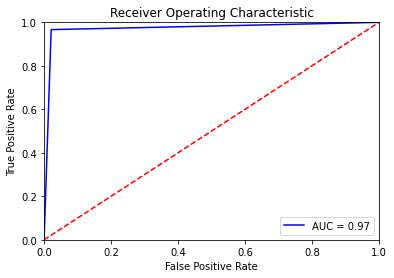

[[1106   24]
 [   4  116]]


In [ ]:
model= KNeighborsClassifier(n_neighbors=5)
modeltest(Xtrainres,Xtest,ytrainres,ytest,model)

Both of our KNeighborsClassifier with 5 neighbour and and Neural network model perform same and thus those two are our best model

**CONCLUSION :**
 The aim of the bank is to convert there liability customers into loan customers. They want to set up a new marketing campaign; hence, they need information about the connection between the variables given in the data. five classification algorithms were used in this study. From which, it seems like KNeighborsClassifier with 5 neighbour and and Neural network model has higest recall and auc score and we can choose that as our final model.
      among all the attribute only 5 turn out to be usefull which where related
to their savings family size education spending. 
getting right information is essential to predict whether a customer will take loan or not .      


----------------------------------------------------------------------------------------------------